# Bibliotecas e Funções

In [1]:
# Usado para ler arquivos, carregar código personalizado e ter acesso a outros recursos de sistema
import os
import sys

# Recursos para texto
import re

# Verificação de tipos
from typing import List

# Manipulação e análise dos dados
import pandas as pd
import missingno as msno

# Recursos para visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML, display

# Carregar código personalizado disponível em ../src
sys.path.append(os.path.abspath(os.path.pardir))
from src import settings
from src.utils.notebooks import display_side_by_side
from src.utils.experiments import set_dataset_split

# Configurações para a exibição de conteúdo do Pandas e das bibliotecas gráficas
%matplotlib inline 
sns.set(rc={'figure.figsize':(25,10)})
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', 150)

# Contextualização

O objetivo deste notebook é explorar os dados fornecidos pelo Elo7 para trabalhar com os problemas de classificação de produtos em categorias (supervisionado) e classificação da intenção dos usuários a partir dos termos de busca (não supervisionado). Conforme a [descrição do case](https://github.com/SamaraAlves/teste_HT):

> O dataset escolhido para esse teste é composto de uma amostra de dados do Elo7. Você pode obter o dataset através desse link (se tiver problemas para obter os dados, por favor, nos avise que ajudaremos você).
> 
> Em resumo, o dataset contém 38.507 registros distribuídos em 5 categorias (Bebê, Bijuterias e Jóias, Decoração, Lembrancinhas, Papel e Cia e Outros). Cada registro corresponde a um clique em um produto a partir de um termo de busca no site.
> 
> Nesse dataset você encontrará as seguintes colunas:
> 
> - **product_id** - identificação de produto
> - **seller_id** - identificação do vendedor
> - **query** - termo de busca inserido pelo usuário
> - **search_page** - número da página que o produto apareceu nos resultados de busca (mín 1 e máx 5)
> - **position** - número da posição que o produto apareceu dentro da página de busca (mín 0 e máx 38)
> - **title** - título do produto
> - **concatenated_tags** - tags do produto inseridas pelo vendedor (as tags estão concatenadas por espaço)
> - **creation_date** - data de criação do produto na plataforma do Elo7
> - **price** - preço do produto em reais
> - **weight** - peso em gramas da unidade do produto reportado pelo vendedor
> - **express_delivery** - indica se o produto é pronta entrega (1) ou não (0)
> - **minimum_quantity** - quantidade de unidades mínima necessária para compra
> - **view_counts** - número de cliques no produto nos últimos três meses
> - **order_counts** - número de vezes que o produto foi comprado nos últimos três meses
> - **category** - categoria do produto


É possível entender melhor a origem e o significado dos dados a partir da página de busca do Elo7. Na tela inicial, o usuário pode visualizar categorias de produtos, o campo de busca e alguns produtos disponíveis.

![Image](./assets/tela_inicial_busca_formatada.png)  

Ao submeter termos de busca, o usuário é levado à página de resultados.


![Image](./assets/tela_resultados_busca_formatada.png) 

Pela imagens de busca, é possível notar que o número máximo de páginas de resultados pode exceder o limite de 5 presente nos dados. Além disso, os critérios de ordenação podem influenciar a posição de cada produto na página para um mesmo resultado de busca.

Caso o usuário clique em um produto, a tela de apresentação é exibida.

![Image](./assets/tela_apresentacao_produto_formatada.png) 

É possível ver que categorias têm uma construção hierárquica, apesar de os dados terem apenas o último nível. Além disso, o número de tags pode ser bem variado, o que pode ser melhor caracterizado ao analisar os dados.

A presença de um sistema de avaliação dos vendedores mostra que a reputação do vendedor pode ser um fator de influência nos cliques e vendas. 



# Resumo

Este resumo, em processo de desenvolvimento, lista os principais achados e preocupações que devem ser considerados durante a criação dos modelos supervisionados e não supervisionados:
 - Pela natureza do projeto, que envolve a criação frequente de novos produtos e tem diferentes padrões de descrição por parte dos usuários, sejam eles vendedores ou compradores, é preciso ter a preocupação com valores textuais novos relacionados a títulos, tags e consultas.
 - Há valores não preenchidos na coluna de contagem de pedido.
 - A concatenação das tags parece provocar uma perda, ao fazer a decomposição dos elementos, com relação às expressões compostas que formariam uma tag única.
 - As tags já são pre-processadas e normalizadas. Isso deve reduzir o esforço de tratamento dos dados, mas pode ter um impacto em algumas formas de se trabalar com o texto, pela não correspondência entre as palavras que teriam acentuação.
 - Há um grande desbalanceamento de categorias, que tende a manter a mesma ordem de categorias mais frequentes ao longo do tempo, então é preciso fazer algum tratamento na criação do modelo (provavelmente usar balanceamento por peso ou amostragem).
 
# Ideias

## Com potencial de exploração
 - Transformação dos dados e engenharia de características:
     - Criar proporção entre visualizações e pedidos;
     - Descartar tags poucos significativas em produtos com número grande de tags 
         - Usar *n* primeiras tags;
         - Criar "tags qualificadas" verificando quais ocorrem no título ou na busca;
         - Filtrar com base na própria noção de relevância por TF-IDF.
 - Aumentação de dados para texto: 
     - Fazer tradução e retradução de texto para obter variações das mesmas consultas;
     - Usar ontologia/tesauro/embeddings para obter palavras ou tags semelhantes;
 - Fazer fine tune de modelo (e.g., BERT ou Word2Vec) com base na busca. Como todos os registros são de cliques, que indicam casos positivos, poderiam ser criados exemplos negativos usando produtos que não têm interseção com termos de busca, tag e título. Tanto o modelo em si, quanto os embeddings poderiam ser usados.
 - TF-IDF pode ser alternativa simples e eficaz considerando que as palavras já são em grande parte normalizadas. 
 
# Sem potencial ou inviáveis
 - Criar noção de tendência de interesse: pela falta da data de realização da consulta, não é possível determinar se há aumento ou redução de interesse em uma janela de tempo;
 

# Análise Exploratória

A exploração dos dados será feita a partir do conjunto de treinamento gerado no notebook [01_Estruturacao.ipynb](01_Estruturacao.ipynb). Com isso, os dados de treinamento ficam isolados e podem ser utilizados para fazer uma avaliação da eficácia dos modelos em dados novos, como ocorreria em produção.

In [2]:
frame = pd.read_csv(os.path.join(settings.DATA_PATH, 'interim', 'training.csv'))

In [3]:
print(f'Registros: {len(frame)}.')

frame.head(10)

Registros: 32746.


,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category,period
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração,2015-11
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos long drink canecas,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia,2018-04
2,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê,2017-02
3,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração,2017-05
4,4336889,3436479,dia dos pais,1,37,Álbum de figurinhas dia dos pais,albuns figurinhas pai lucas album fotos,2018-07-11 10:41:33,49.970000,208.0,1,1,1093,NaN,Lembrancinhas,2018-07
5,7544556,7118324,arranjo de flores para mesa,1,9,Arranjo de Flores - Orquidias,mini arranjos,2016-04-22 13:34:16,23.670000,207.0,1,5,276,NaN,Decoração,2016-04
6,10869150,5203458,lembrancinha maternidade,5,18,Kit Aromarizador + sacola / Lembrancinha Maternidade,bb lembrancinhas maternidade baby lembranca maternidade bebe conforto lembrancinha maternidade,2017-10-05 00:26:02,12.710000,55.0,0,33,1178,109.0,Lembrancinhas,2017-10
7,13193769,2933585,chaveiro dia dos pais,1,35,chaveiro dia dos pais,dia pais,2018-07-04 12:47:49,11.420000,6.0,1,23,72,NaN,Lembrancinhas,2018-07
8,13424151,8530613,manta personalizada,1,20,Manta para bebê personalizada de Nuvem com nome,nascimento manta baby cha bebe vestido bebe,2018-04-03 16:10:51,107.100000,9.0,1,1,639,26.0,Bebê,2018-04
9,12595651,5371868,pais,1,28,Chinelo Dia dos Pais,sandalia dia pais,2018-06-25 23:23:14,17.390000,6.0,1,22,933,NaN,Lembrancinhas,2018-06


## Transformação dos Tipos de Dados

Para permitir que cada elemento do conjunto de dados seja analisado adequadamente, os tipos das colunas serão transformados.

In [4]:
frame = pd.read_csv(os.path.join(settings.DATA_PATH, 'interim', 'training.csv'))

# Mapeamento de colunas e tipos que devem ser atribuídos
columns_types = {'product_id': 'category',
                 'seller_id': 'category',
                 'query': 'string',
                 'search_page': 'int64',
                 'position': 'int64',
                 'title': 'string',
                 'concatenated_tags': 'string',
                 'creation_date': 'datetime64',
                 'price': 'float64',
                 'weight': 'float64',
                 'express_delivery': 'bool',
                 'minimum_quantity': 'int64',
                 'view_counts': 'int64',
                 'order_counts': 'float64',
                 'category': 'category',
                 'period': 'category'
                }

# Manter tipos originais
original_types_frame = pd.DataFrame(frame.dtypes, columns=['Original'])

# Converter tipos e mapear os novos
frame = frame.astype(columns_types)
types_frame = pd.concat([original_types_frame, 
                         pd.DataFrame(frame.dtypes, columns=['Transformado'])], axis=1)

# Mostrar resultados
display_side_by_side([types_frame], ['Comparação entre Tipos Originais e Novos'])

del original_types_frame, types_frame

,Original,Transformado
product_id,int64,category
seller_id,int64,category
query,object,string
search_page,int64,int64
position,int64,int64
title,object,string
concatenated_tags,object,string
creation_date,object,datetime64[ns]
price,float64,float64
weight,float64,float64


## Sumarização dos Valores das Colunas

Com os tipos transformados, é possível obter uma visão geral do comportamento dos dados de acordo com sua natureza (numérica ou categórica). Uma visão semelhante tinha sido obtida no primeiro notebook (01_Estruturacao.ipynb), mas ela foi feita apenas para um produto, sem evitando a utilização de dados do conjunto de teste.

In [5]:
# Mapear tipos de colunas e separá-las
categorical_types = ['category', 'string', 'bool']
categorical_columns = [key for key, value in columns_types.items() if value in set(categorical_types)]
numeric_columns = [key for key, value in columns_types.items() if value not in set(categorical_types)]

# Mostrar descrição das colunas por tipo de dados
display_side_by_side([frame[numeric_columns].describe(include='all', datetime_is_numeric=True),
                     frame[categorical_columns].describe(include='all')],
                     ['Colunas Numéricas', 'Colunas Categóricas'])

del columns_types, categorical_types, categorical_columns, numeric_columns

,search_page,position,creation_date,price,weight,minimum_quantity,view_counts,order_counts
count,32746.000000,32746.000000,32746,32746.000000,32688.000000,32746.000000,32746.000000,15736.000000
mean,1.497557,16.733006,2017-04-23 04:49:03.134795264,83.253023,344.624572,15.089385,565.709369,27.598246
min,1.000000,0.000000,2008-11-05 22:57:17,0.080000,0.000000,0.000000,1.000000,1.000000
25%,1.000000,6.000000,2016-10-26 02:27:43.500000,12.690000,6.000000,3.000000,130.000000,8.000000
50%,1.000000,16.000000,2017-09-03 15:24:02,27.805000,9.000000,7.000000,259.000000,15.000000
75%,2.000000,27.000000,2018-04-09 17:28:10.500000,91.800000,106.000000,17.000000,546.000000,26.000000
max,5.000000,38.000000,2018-08-31 23:53:12,6289.420000,65009.000000,3000.000000,34061.000000,2460.000000
std,0.985655,11.598638,NaN,200.388410,1705.857187,46.206338,1365.994604,61.397492
,product_id,seller_id,query,title,concatenated_tags,express_delivery,category,period
count,32746,32746,32746,32746,32744,32746,32746,32746


Algumas observações que podem ser feitas sobre a visão descritiva dos valores numéricos indica:
 - **Até 75%** dos cliques de produtos ocorreram **até a 2ª página** dos resultados de busca, sendo que o maior número de páginas dessa amostra é 5.
 - **Até 50%** dos cliques ocorrem até **a posição 16 da página**. Enquanto o valor máximo de posição nos dados é 38, a página atual de resultados de busca do Elo7 exibe 40 itens. Esse resultado pode indicar que parte considerável dos usuários não chega ao fim da página para acessar uma outra página de resultado, conforme o item anterior.
 - Os **produtos** disponíveis foram **criados em um período de até 10 anos**. Pelo fato de a metade dos registros abranger o período de 2008 a 2017 e a segunda metade considerar 2017 e 2018, é possível entender que **há mais dados sobre produtos mais recentes**, o que pode estar relacionado a um número de cliques maior ou a uma quantidade maior de produtos.
 - A variação de pesos vai de 15 g a 65 kg, com a **predominância de produtos leves**, de até 106g. Provavelmente móveis e produtos mais pesados estão influenciando a média e o desvio padrão.
 - A quantidade mínima pode chegar a 3000 itens, mas **até 75% dos registros possuem a quantidade mínima de até 17**.
 - A **contagem de visualizações**, que considera a janela de 3 meses, possui **valores acima de 100 já para os primeiros 25% dos registros**. Mesmo com essa janela, há produtos bastante propulares, com mais de 30.000 visualizações.
 - A **contagem de pedidos** tem **valor mínimo de 1**. É preciso verificar se a ausência de pedidos não está sendo identificada como um valor não preenchido.
 

Sobre os valores categóricos:
 - Grande parte dos produtos têm apenas uma ocorrência (**~77% dos registros são de produtos únicos**);
 - Há maior repetição de vendedores. São cerca de **4 registros por vendedor**.
 - Há considerável repetição de consultas. São cerca de **6 registros por consulta**.
 - Os **títulos de produtos* são mais diversos**, sendo 65% únicos.
 - A combinação de todas as tags tem diversidade semelhante à de títulos, mas uma análise por tags individuais deve ser mais adequada.
 - Produtos à **pronta entrega** são mais frequentes, com quase **80% dos casos**.
 - Das 6 categorias, **'Lembracinhas' é a mais fequente**, com cerca de 46% dos casos.
 - Da combinação de ano e mês, **Julho de 2018** é a que tem maior quantidade de registros, com **6% do total** que possui 115 combinações.

## Análise de Valores Ausentes

Para complementar a visão dos dados, é importante verificar se há valores não preenchidos. Uma primeira visão é ter a noção de quais colunas apresentam algum valor ausente e em qual frequência isso ocorre.

<AxesSubplot:>

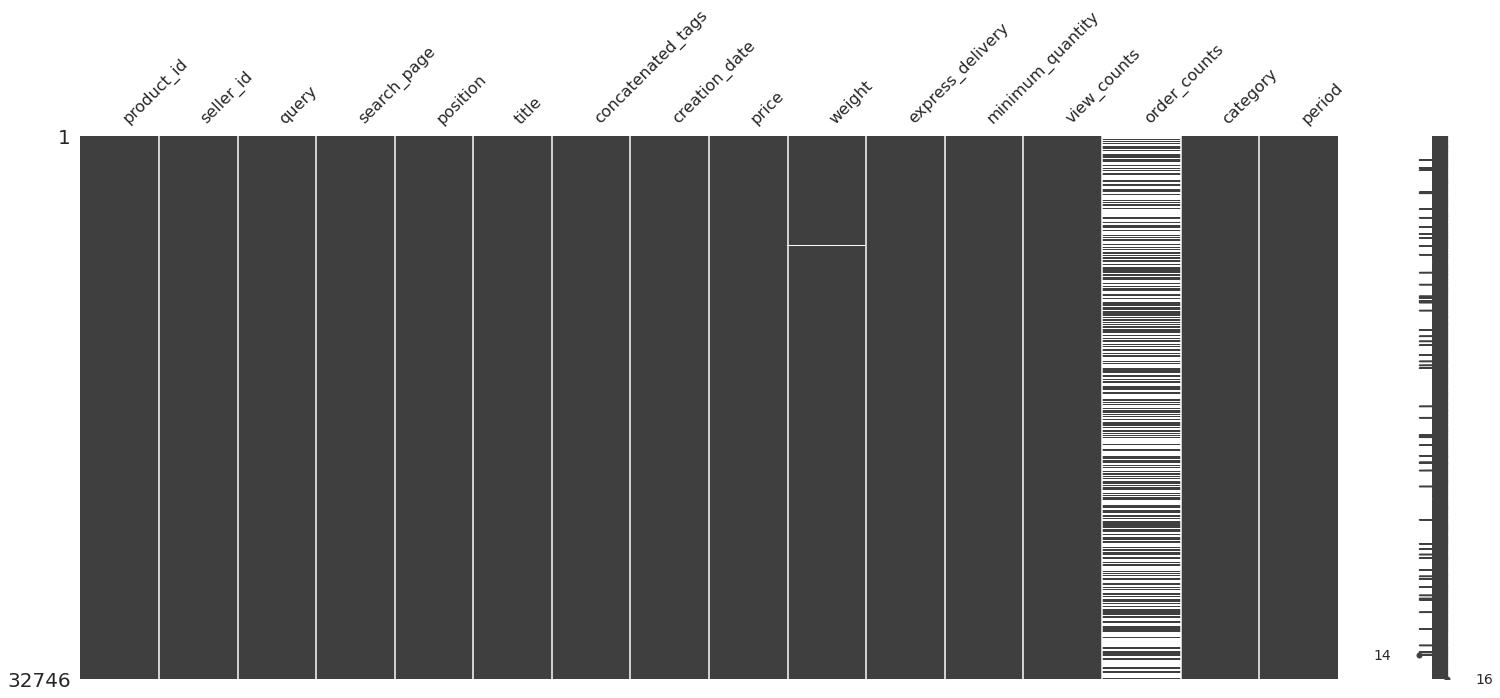

In [6]:
msno.matrix(frame)

Conforme a imagem apresenta, as colunas **weight** e **order_counts** possuem valores vazios. Enquanto a primeira possui apenas uma ocorrência, que pode ser descartada ou tratada, a segunda possui uma quantidade maior. 

Como se trata de uma base de dados bem controlada, parece improvável que a ausência de valores ocorra por algum erro ou má qualidade dos dados. Uma hipótese é a de que produtos sem pedidos nos últimos 3 meses estejam sendo representados com valor ausente em vez de valor 0.

In [7]:
# Gerar agregação com o total de registros e a contabilização de quantos não foram preenchidos
missing_order_counts_frame = (
    frame
    [['product_id', 'order_counts']]
    .assign(is_missing=lambda f: f['order_counts'].isna())
    .assign(registros=1)
    .groupby('product_id')
    .sum()
    .reset_index()
    .assign(diferenca=lambda f: f['registros'] - f['is_missing'])
    .sort_values(by=['is_missing', 'registros'], ascending=[False, False])
)

display_side_by_side([missing_order_counts_frame.head(15),
                      (missing_order_counts_frame
                       .loc[lambda f: f['is_missing'] > 0]
                       .sort_values(by=['diferenca', 'registros'], ascending=[False, False])
                       .head(15))
                     ],
                     ['Produtos com Maior Frequência de Valores Ausentes',
                      'Produtos Com alguns Valores Ausentes'],
                    padding=100)

,product_id,order_counts,is_missing,registros,diferenca
16700,11130723,0.0,12,12,0
21351,14155651,0.0,11,11,0
8062,5395219,0.0,10,10,0
11583,7747109,0.0,10,10,0
6514,4336889,0.0,9,9,0
10369,6916970,0.0,9,9,0
10434,6960600,0.0,9,9,0
13814,9180973,0.0,9,9,0
934,599278,5.0,7,8,1
18557,12350793,12.0,7,8,1


Como é possível observar, há produtos em que todos os registros têm o contador de pedidos nulo, enquanto há outros em que alguns registros estão nulos e outros não. Alguns desses casos com situações mistas de prenchimento serão visualizados.

In [8]:
# Dados os 3 IDs de produtos com mais valores ausentes, mostrar o histórico de registros
for product_id in [11596456, 384860, 1217193]:
    sub_frame = frame.loc[lambda f: f['product_id'] == product_id]
    display(HTML(f'<h4>{sub_frame["title"].iloc[0]}</h4>'))
    display(sub_frame.sort_values(by=['product_id', 'view_counts', 'order_counts']))
    
del sub_frame

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category,period
6081,11596456,2133131,lembrancinhas,5,33,lembrancinhas de casamento,lembranca casamento arquivos silhouette lembrancinha casamento casamento lembrancinha,2016-01-04 15:24:06,1.97,7.0,True,6,2196,16.0,Lembrancinhas,2016-01
13013,11596456,2133131,lembrancinha de casamento,1,20,lembrancinhas de casamento,lembranca casamento arquivos silhouette lembrancinha casamento casamento lembrancinha,2016-01-04 15:24:06,12.41,6.0,True,10,2196,NaN,Lembrancinhas,2016-01
21990,11596456,2133131,lembrancinhas de casamento,1,6,lembrancinhas de casamento,lembranca casamento arquivos silhouette lembrancinha casamento casamento lembrancinha,2016-01-04 15:24:06,10.63,8.0,True,11,2196,NaN,Lembrancinhas,2016-01
21514,11596456,2133131,lembrancinha para casamento,1,9,lembrancinhas de casamento,lembranca casamento arquivos silhouette lembrancinha casamento casamento lembrancinha,2016-01-04 15:24:06,1.97,5.0,True,11,2213,NaN,Lembrancinhas,2016-01
10702,11596456,2133131,casamento,2,27,lembrancinhas de casamento,lembranca casamento arquivos silhouette lembrancinha casamento casamento lembrancinha,2016-01-04 15:24:06,11.76,8.0,True,10,2216,NaN,Lembrancinhas,2016-01
19231,11596456,2133131,casamento,2,27,lembrancinhas de casamento,lembranca casamento arquivos silhouette lembrancinha casamento casamento lembrancinha,2016-01-04 15:24:06,10.87,6.0,True,6,2243,24.0,Lembrancinhas,2016-01
24900,11596456,2133131,lembrancinha casamento,4,5,lembrancinhas de casamento,lembranca casamento arquivos silhouette lembrancinha casamento casamento lembrancinha,2016-01-04 15:24:06,1.97,0.0,True,12,2248,NaN,Lembrancinhas,2016-01
14526,11596456,2133131,lembrancinhas para casamento,1,5,lembrancinhas de casamento,lembranca casamento arquivos silhouette lembrancinha casamento casamento lembrancinha,2016-01-04 15:24:06,10.90,9.0,True,6,2264,NaN,Lembrancinhas,2016-01


,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category,period
1110,384860,7461314,lembrancinhas para o dia dos pais gravata de eva,1,0,Lembrancinha gravata chaveiro,tacas casamento dia pais religiosa chaveiro gravata gravata,2016-03-02 21:42:21,9.92,8.0,True,29,757,22.0,Lembrancinhas,2016-03
12076,384860,7461314,lembrancinha dia dos pais eva,1,23,Lembrancinha gravata chaveiro,tacas casamento dia pais religiosa chaveiro gravata gravata,2016-03-02 21:42:21,9.47,5.0,True,29,757,NaN,Lembrancinhas,2016-03
23207,384860,7461314,lembrancinhas para o dia dos pais chaveiro gravata,1,1,Lembrancinha gravata chaveiro,tacas casamento dia pais religiosa chaveiro gravata gravata,2016-03-02 21:42:21,0.59,6.0,True,25,757,NaN,Lembrancinhas,2016-03
25806,384860,7461314,lembrancinha dia dos pais,5,14,Lembrancinha gravata chaveiro,tacas casamento dia pais religiosa chaveiro gravata gravata,2016-03-02 21:42:21,0.59,6.0,True,32,757,NaN,Lembrancinhas,2016-03
5493,384860,7461314,lembrancinha de eva para dias dos pais fasiu de,1,28,Lembrancinha gravata chaveiro,tacas casamento dia pais religiosa chaveiro gravata gravata,2016-03-02 21:42:21,11.10,6.0,True,28,777,NaN,Lembrancinhas,2016-03
29990,384860,7461314,chaveiro de eva para o dia dos pais,1,26,Lembrancinha gravata chaveiro,tacas casamento dia pais religiosa chaveiro gravata gravata,2016-03-02 21:42:21,10.71,8.0,True,25,785,NaN,Lembrancinhas,2016-03
16575,384860,7461314,lembrancinha dia dos pais,5,14,Lembrancinha gravata chaveiro,tacas casamento dia pais religiosa chaveiro gravata gravata,2016-03-02 21:42:21,9.94,6.0,True,36,812,17.0,Lembrancinhas,2016-03


,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category,period
15488,1217193,4315729,toy story 4,1,6,forminha toy story,caixinhas doce festa toy story aniversario toy story festa pedro niver toy story forminha 4 petalas,2016-01-24 22:24:27,10.09,0.0,True,100,431,18.0,Lembrancinhas,2016-01
5213,1217193,4315729,toy story,2,3,forminha toy story,caixinhas doce festa toy story aniversario toy story festa pedro niver toy story forminha 4 petalas,2016-01-24 22:24:27,10.52,9.0,False,100,431,NaN,Lembrancinhas,2016-01
30841,1217193,4315729,toy story,2,3,forminha toy story,caixinhas doce festa toy story aniversario toy story festa pedro niver toy story forminha 4 petalas,2016-01-24 22:24:27,8.74,0.0,True,104,431,NaN,Lembrancinhas,2016-01
15650,1217193,4315729,toy story,5,22,forminha toy story,caixinhas doce festa toy story aniversario toy story festa pedro niver toy story forminha 4 petalas,2016-01-24 22:24:27,9.25,6.0,True,100,451,6.0,Lembrancinhas,2016-01
17733,1217193,4315729,toy story,5,22,forminha toy story,caixinhas doce festa toy story aniversario toy story festa pedro niver toy story forminha 4 petalas,2016-01-24 22:24:27,9.51,0.0,False,108,466,NaN,Lembrancinhas,2016-01
16317,1217193,4315729,toy story,2,3,forminha toy story,caixinhas doce festa toy story aniversario toy story festa pedro niver toy story forminha 4 petalas,2016-01-24 22:24:27,9.05,8.0,True,108,472,NaN,Lembrancinhas,2016-01


Ainda que não se possível garantir que a ordem de visualização seja garantida, ordenar produtos pela quantidade de visualizações pode se aproximar da ordem cronológica de existência e acessos ao produto. Considerando isso, poderia se esperar que a quantidade de pedidos fosse relativamente próxima para outras ocorrências do mesmo produto que tivessem o mesmo total de visualizações. Isso, porém, não ocorre, conforme o produto *lembrancinhas de casamento*.

É possível observar, com relação aos três produtos, que há variações de outros atributos mesmo quando a contagem de visualizações é a mesma. Isso pode tanto indicar uma diferença no tempo, quanto alguma regra de negócio que zera o total de pedidos com a mudança das características de um produto -- apesar de ser o mesmo produto à venda pelo mesmo vendedor.

A seguir, tenta-se verificar se há alguma correlação que ajude a explicar a ocorrência de valores ausentes.

<AxesSubplot:>

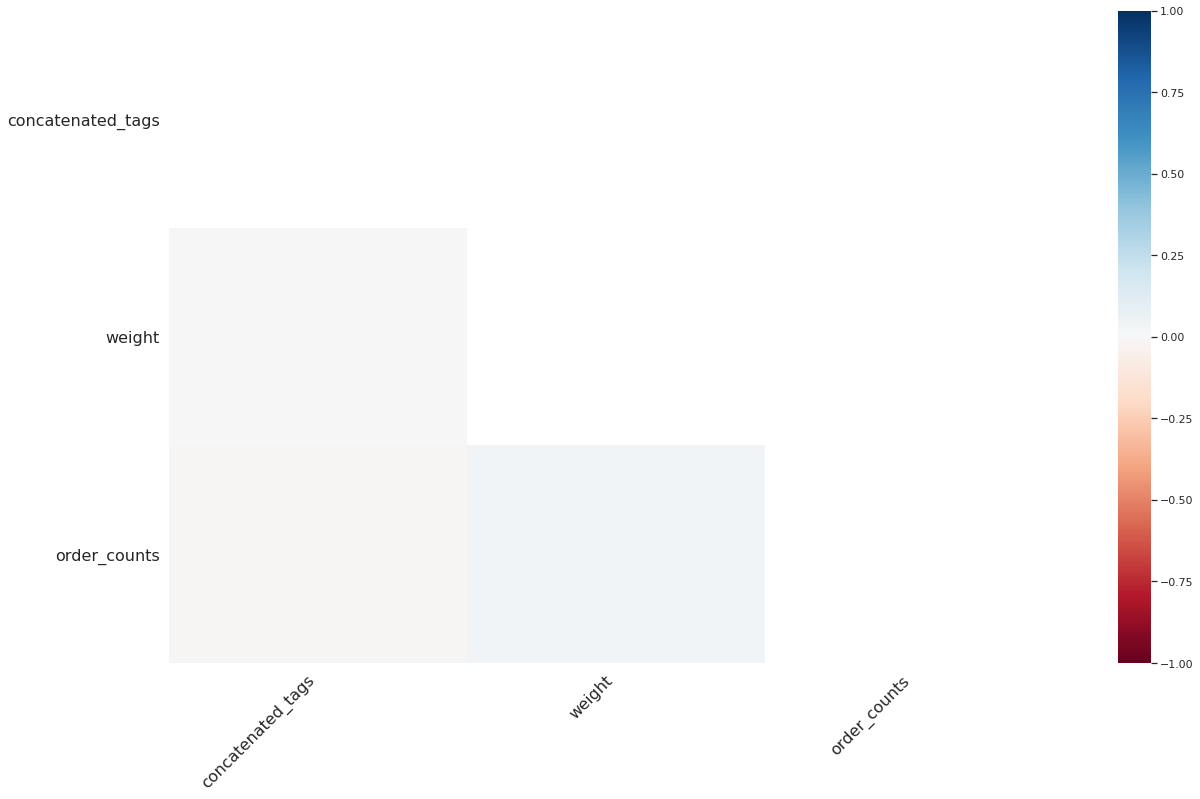

In [9]:
msno.heatmap(frame)

Pelo mapa de calor de correlações, não é possível determinar uma correlação alta. O elemento com maior correlação é peso, que realmente varia nos 3 casos analisados. Ainda assim, é uma correlação baixa.

Para se lidar com os casos de valores ausentes, duas estratégias que podem ser seguidas na fase de desenvolvimento do modelo:
 - Utilizar média ou mediana (com relação ao próprio produto, à sua categoria ou a produtos com características semelhantes) para fazer a imputação;
 - Empregar algoritmos que permitam a utilização de valores ausentes.

## Análise de Colunas

Nesta seção serão analisadas em maior detalhe algumas colunas que podem representar entidades ou valores que podem ser determinantes neste estudo. Outras colunas, sobretudo com valor essencialmente numérico, podem ser mantidas apenas no nível de sumarização estatística, feita na seção [Sumarização dos Valores das Colunas](#Sumarização-dos-Valores-das-Colunas).

### Entendimento sobre Produtos

Para entender os dados e como modelar melhor o problema, serão feitas algumas verificações com o intuito de entender:
 - Um mesmo produto pode ser vendido por mais de um vendedor?
 - O título de um produto se repete entre vendedores diferentes?
 - Um produto pode apresentar tags diferentes?
 - Produtos com títulos diferentes podem apresentar tags diferentes?
 
A seguir são feitas algumas agregações dos dados para viabilizar o entendimento das questões supracitadas.

In [10]:
def aggregate_by_columns(base_frame: pd.DataFrame, columns:List[str], group_columns:List[str], records: int=10) -> pd.DataFrame:
    """Função para repetir a agregação dos dados baseados em listas de colunas"""

    agg_frame = (
        base_frame
        [columns]
        .drop_duplicates()
        .assign(ocorrencias_unicas=1)
        .groupby(group_columns)
        .sum()
        .reset_index()
        .sort_values(by='ocorrencias_unicas', ascending=False)
        .head(records)
    )

    return agg_frame

display_side_by_side([aggregate_by_columns(frame, ['product_id', 'seller_id'], ['product_id']),
                      aggregate_by_columns(frame, ['title', 'seller_id'], ['title']),
                      aggregate_by_columns(frame, ['concatenated_tags', 'product_id'], ['product_id']),
                      aggregate_by_columns(frame, ['concatenated_tags', 'title'], ['title'])
                     ],
                     ['Vendedores por Produto',
                      'Vendedores por Títulos de Produto',
                      'Tags por Produto',
                      'Tags por Títulos de Produto'],
                     padding=50)

,product_id,ocorrencias_unicas
0,361,1
16779,11197600,1
16777,11196802,1
16776,11196229,1
16775,11193657,1
16774,11193421,1
16773,11193205,1
16772,11192919,1
16771,11192834,1
16770,11192140,1


 A partir dos dados apresentados, é possível entender: 
 - Um mesmo produto pode ser vendido por mais de um vendedor?
 > Aparentemente não.
 - O título de um produto se repete entre vendedores diferentes?
 > Há vários produtos vendidos por diferentes pessoas.
 - Um produto pode apresentar tags diferentes?
 > Tags não parecem variar para o mesmo produto.
 - Produtos com títulos diferentes podem apresentar tags diferentes?
 > Sim, há diversidade de tags, mesmo entre produtos com o mesmo título.

## Entendimento sobre Tags

Nesta seção serão exploradas as características das tags. O primeiro passo é entender a distribuição do tamanho e identificar casos com texto mais longo, que devem permitir um entendimento melhor do desafio que será decompor as tags novamente.

Algumas das questões que se quer responder:
 - Há tags compostas por múltiplas palavras?   
 - É possível restaurar tags com múltiplas palavras (caso existam)? 
 - As tags estão tratadas?
 - Há grande variação na quantidade de tags por produto?

 - Tamanho: 870 | Conteúdo: chaveiros plantinhas joaquim almofada 2 anos bernardo formatura alfabeto garotinho ideias casamento festa bosque aniversario 1 ano marina dino decoracoes cha marcela aniversario victor thais niver 90 60 gravity falls batizado lembrancinha casamento toy stories niver 33 lembrancinhas maternidade cha bebe lhama esther 1 ano cha bebe giulia casamento rustico lembrancinhas casorio lembrancinha jardim encantado lembrancas presentear festa baby inspirations suculentas taca cha bebe aniversario theo niver brindes filha leve noivado aniversario mauri 41 anos cha lorenzo lembrancinhas casamento convite padrinhos lembrancinha maternidade lembrancinhas maite 43 ju t anne 1 dinossauros bat alicia bebe festa passarinho festas luisa festa bel aniversario luiza lembrancinhas casamento batizado arthur suculenta lembranca saquinho cha 40 enfermagem pandinha baby lembrancinha

 - Tamanho: 695 | Conteúdo: decoracao quarto meninas lulu girl banquinhos olhinhos decoracao melinda

,tamanho
count,20255.000000
mean,49.407801
std,41.519068
min,0.000000
25%,24.000000
50%,38.000000
75%,62.000000
max,870.000000


,concatenated_tags,tamanho


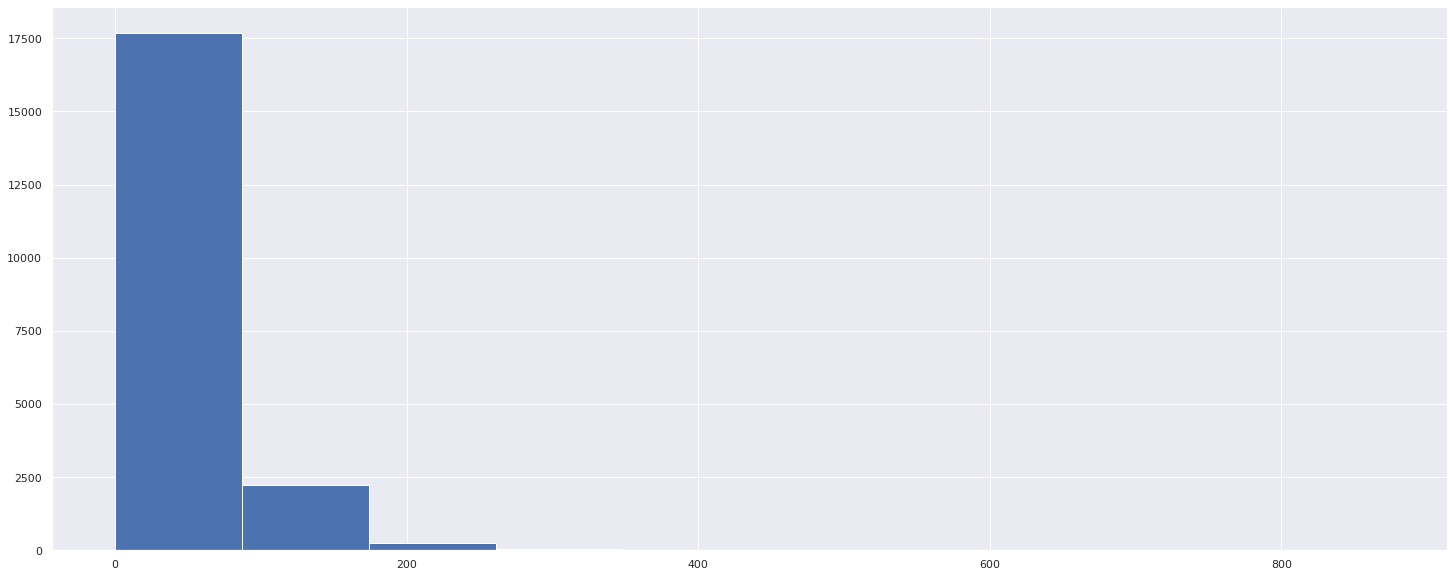

In [11]:
# Criar data frame com o tamanho das tags únicas
raw_tags_frame = (
    frame
    [['concatenated_tags']]
    .drop_duplicates()
    .assign(tamanho=lambda f: f['concatenated_tags'].apply(lambda x: len(str(x)) if not pd.isna(x) else 0))
)

# Analisar tags concatenadas por tamanho
display(HTML('<h4>As Tags Concatenadas Mais Longas</h4>'))

sub_frame = (
    raw_tags_frame
    .sort_values(by='tamanho', ascending=False)
    .head(5)
)

for i, item in sub_frame.iterrows():
    print(f' - Tamanho: {item["tamanho"]} | Conteúdo: {item["concatenated_tags"]}\n')

# Usar a sumarização numérica do tamanho das tags concatenadas
display(HTML('<h4>Resumo das Tags Concatenadas Únicas</h4>'))
display(raw_tags_frame[['tamanho']].describe())

# Verificar se há presença de acentuação
display(HTML('<h4>Registros de Tags com Acentuação</h4>'))
search_pattern = re.compile(r'[áãàéíóõç]', flags=re.IGNORECASE)

display(
    raw_tags_frame
    .loc[lambda f: f['concatenated_tags'].apply(lambda x: search_pattern.search(str(x)) != None)]
    .head(5)
)


# Mostrar histograma com a distribuição dos tamanhos
display(HTML('<h4>Distribuição do Tamanho das Tags Concatenadas Únicas</h4>'))
(
    raw_tags_frame
    ['tamanho']
    .hist()
)


del raw_tags_frame, sub_frame

Conforme observado, a grande maioria das tags têm tamanho menor do que 100 caracteres. No entanto, há casos em que o valor excede 800 caracteres.

Considerando esses casos com maior tamanho, é possível notar alguns pontos:
 - O texto das tags já está tratado com relação à captalização das letras e remoção de acentos, mas há outros caracteres especiais envolvidos (e.g., *'*, *[*, *]* e *?*) 	;
 - Exceto quando há o uso de '_' ou outros caracteres especiais, não é possível reverter facilemnte tags compostas (e.g., 'cha de bebe' e 'bem casado');
 - Não basta separar as tags por espaço, é preciso usar múltiplos caracteres para fazer a decomposição das tags.
 
A seguir, as tags serão segmentadas e analisadas.

In [12]:
agg_frame = (
    frame
    .drop_duplicates('product_id')
    [['concatenated_tags']]    
    .assign(registros=1)
    .groupby('concatenated_tags')
    .sum()
    .reset_index()
    .sort_values(by='registros', ascending=False)
)

tag_split_pattern = re.compile(r"(\s|[-/,;.()])")

exploded_frame = (
    frame
    .drop_duplicates('product_id')
    .assign(tag=lambda f: f['concatenated_tags'].apply(lambda x: tag_split_pattern.split(str(x))))    
    .explode('tag')
    .loc[lambda f: f['tag'].apply(lambda x: len(x.strip()) > 0)]
)

agg_exploded_frame =(
    exploded_frame
    [['tag']]
    .assign(registros=1)
    .groupby('tag')
    .sum()
    .reset_index()
    .sort_values(by='registros', ascending=False)
)

display_side_by_side([agg_frame.head(20),
                      agg_exploded_frame.head(20)], 
                     ['Tags Concatenadas',
                      'Tags Separadas'],
                     padding=50)

del agg_frame, agg_exploded_frame

,concatenated_tags,registros
7417,dia pais,254
11603,lembrancinhas,138
2140,batizado,78
19142,tapetes,58
6995,decoracao,48
4966,casamento,45
7499,dia professores,38
2715,bebe,36
6727,cortinas,31
14170,natal,27


Para verificar se há casos adicionais de tags que não foram corretamente segmentadas, alguns critérios adicionais são utilizados para filtrar e mostrar resultados.

In [13]:
filtered_exploded_frame =(
    exploded_frame
    [['tag']]
    .drop_duplicates()
    .assign(tamanho=lambda f: f['tag'].apply(lambda x: len(str(x)) if not pd.isna(x) else 0))
    .sort_values(by='tamanho', ascending=False)
    .head(20)
)

display_side_by_side([filtered_exploded_frame],
                     ['Tags Individuais'],
                     padding=20)

del filtered_exploded_frame

,tag,tamanho
8529,querooooooooooooooooooo,23
2949,chapeuzinho_vermelho,20
17811,niver1anofernandinho,20
2948,caneca_personalizada,20
3511,batizado_eucaristia,19
12338,papelaria_arq_steel,19
25582,especialdeficiencia,19
20073,krskrakrskrskrskrs,18
5174,galinha_pintadinha,18
1389,angel'smbrancinhas,18


In [14]:
agg_exploded_frame =(
    exploded_frame
    [['product_id']]
    .assign(registros=1)
    .groupby('product_id')
    .sum()
    .reset_index()
    .sort_values(by='registros', ascending=False)
)

display_side_by_side([agg_exploded_frame.head(10),
                      pd.DataFrame(agg_exploded_frame['registros'].describe())],
                     ['Produtos com mais Tags',
                      'Sumarização das Tags'],
                     padding=100)

del agg_exploded_frame

,product_id,registros
12414,8271183,115
8082,5405748,100
11052,7360718,83
13237,8814150,74
6341,4219999,70
7877,5267447,67
24209,16070144,65
20866,13852121,64
8505,5689644,63
14639,9730357,61


Como resultado da análise, é possível responder as questões feitas anteriormente:
 - Há tags compostas por múltiplas palavras?
   > Sim. Por exemplo "chá de bebê" e "bem casado".
   
 - É possível restaurar tags com múltiplas palavras (caso existam)?
   > Algumas sim, como as separadas por "_". Outras, separadas por espaço, não são de modo simples (podem ser usando NER ou outras formas de análise).
  
 - As tags estão tratadas?
   > São com relação a acentuação, no entanto, há caracteres especiais em uso. Adicionalmente, há casos de tags bastante numerosas (conjunto com mais de 800 caracteres) e deve ser preciso fazer algum tipo de poda de relevância para tornar o resultado de buscas por similaridade.
   
 - Há grande variação na quantidade de tags por produto?
   > Sim. 50% têm até 4 tags, mas há produtos com até 115.

## Entendimento sobre Buscas

Esta seção irá explorar mais características relacionadas à busca, para se obter percepções que ajudem a trabalhar no segundo modelo de classificação. 

Algumas das questões que se quer responder são:
 - Qual a repetição dos critérios de busca?
 - É possível explorar alguns exemplos de busca e ver a exploração através de páginas e posições de itens?
 - Qual a distribuição de quantidade de termos nas buscas?
 - Qual a sobreposição entre os termos das buscas e outros elementos textuais?

In [15]:
# Criar data frame com o total de ocorrência de cada consulta
agg_frame = (
    frame
    [['query']]
    .assign(registros=1)
    .groupby('query')
    .sum()
    .reset_index()
    .sort_values(by='registros', ascending=False)
)

# Guardar a consulta mais repetida
most_frequent_query = agg_frame.iloc[0]['query']

# Criar dataframe com os registros da busca mais frequente
sub_frame = (
    frame
    .loc[lambda f: f['query'] == most_frequent_query]        
    .drop(columns=['weight', 'express_delivery', 'minimum_quantity', 'period', 'price', 'query'])
    .sort_values(by=['search_page', 'position'])
)

# Exibição dos resultados
display_side_by_side([agg_frame.head(10), sub_frame.head(50)],
                     ['Busca mais repetida', 'Histórico de registros associados à busca mais frequente'],
                     padding=50)

del agg_frame, sub_frame

,query,registros
705,bolsa maternidade,139
2117,dia dos pais,130
4762,porta maternidade,122
513,batizado,121
3507,lembrancinha maternidade,119
3736,lembrancinhas maternidade,115
3317,lembrancinha batizado,114
3257,lembrancinha,114
3419,lembrancinha dia dos pais,105
5301,saida maternidade,100


In [16]:
exploded_query_frame = (
    frame
    .drop_duplicates('query')
    .assign(query_term=lambda f: f['query'].apply(lambda x: tag_split_pattern.split(str(x))))    
    .explode('query_term')
    .loc[lambda f: f['query_term'].apply(lambda x: len(x.strip()) > 0)]
)

agg_exploded_frame =(
    exploded_query_frame
    [['query']]
    .assign(registros=1)
    .groupby('query')
    .sum()
    .reset_index()
    .sort_values(by='registros', ascending=False)
)

display_side_by_side([agg_exploded_frame.head(10),
                      pd.DataFrame(agg_exploded_frame['registros'].describe())],
                     ['Buscas com mais termos',
                      'Sumarização dos termos de busca'],
                     padding=100)

del agg_exploded_frame

,query,registros
2961,kit bolsa maternidade categoria bebe nav bolsa maternidade local sao jose do rio preto sp,15
5418,suporte de madeira para vasos de parede suporte de madeira para vasos de flores,14
5417,suporte de madeira para flores na parede suporte de madeira para vasos de plantas,14
1821,cortina voil corta luz blackout blecaute 2 80 x 2 30 branco,12
5706,toalha de mesa bordada em ponto cruz com bicos de croche,11
1795,cortina corta luz black out blecaute 2 80x2 30 cinza pvc,11
2927,kit 2 cortina corta luz blackout blecaute pvc 2 80x2 30cores,11
3591,lembrancinha patrulha canina categoria aniversario e festas nav painel de aniversario,11
1796,cortina corta luz blackout blecaute 2 80x2 30 branca pvc,10
1798,cortina corta luz blackout blecaute 2 80x2 30 cinza pvc,10


Pela análise, as principais respostas enconradas foram:
 - Qual a repetição dos critérios de busca?
 > Até 75% dos das consultas são compostas por 4 elementos. No entanto, há consultas com até 15 termos.
 
 - É possível explorar alguns exemplos de busca e ver a exploração através de páginas e posições de itens?
 > Pela pesquisa com maior histórico de interações, foi possível observar ampla cobertura do número de páginas e itens, mas, como observado na descrição estatística das colunas, a exploração costuma ir até a 2ª página e a 16ª posição.
 
 - Qual a distribuição de quantidade de termos nas buscas?
 > TODO
 
 - Qual a sobreposição entre os termos das buscas e outros elementos textuais?
 > TODO

## Análise de Categorias

Como as categorias são um recurso determinante para a organização do conteúdo e, neste estudo de caso, a principal informação para a classificação, é importante verificar a distribuição de valores e outros aspectos.

Algumas das questões que se quer entender sobre categorias são:
 - Há desbalanceamento entre as classes?
 - Se houver desbalanceamento, ele muda ao longo do tempo?

In [17]:
def simple_aggregation(base_frame: pd.DataFrame, columns: List[str] = None) -> pd.DataFrame:
    "Faz a agregação simples por categoria."

    agg_frame = (
        base_frame
        [['category']]
        .assign(registros=1)
        .groupby('category')
        .sum()
        .reset_index()
        .sort_values(by='registros', ascending=False)
    )
    
    return agg_frame

def aggregate_by_columns(base_frame: pd.DataFrame, columns:List[str], group_columns:List[str], records: int=10) -> pd.DataFrame:
    """Função para repetir a agregação dos dados baseados em listas de colunas"""

    agg_frame = (
        base_frame
        [columns]
        .assign(registros=1)
        .groupby(group_columns)
        .sum()
        .reset_index()
        .sort_values(by='registros', ascending=False)
        .head(records)
    )

    return agg_frame



display_side_by_side([simple_aggregation(frame),
                      simple_aggregation(frame.drop_duplicates('product_id'))], 
                     ['Categorias por Cliques',
                      'Categorias por Produtos Únicos'],
                     padding=50)

,category,registros
3,Lembrancinhas,15085
2,Decoração,7598
0,Bebê,6194
5,Papel e Cia,2150
4,Outros,940
1,Bijuterias e Jóias,779
,category,registros
3,Lembrancinhas,10827
2,Decoração,6300
0,Bebê,4754


Analisando o número de produtos criados por categoria, é possível observar que *Lembrancinhas* se mantém predominante, com algumas raras exceções que ocorrem antes de 2012 ou momentaneamente em 2017. O comportamento das demais categorias também parece se manter relativamente constante, então o desbalanceamento também é constante.

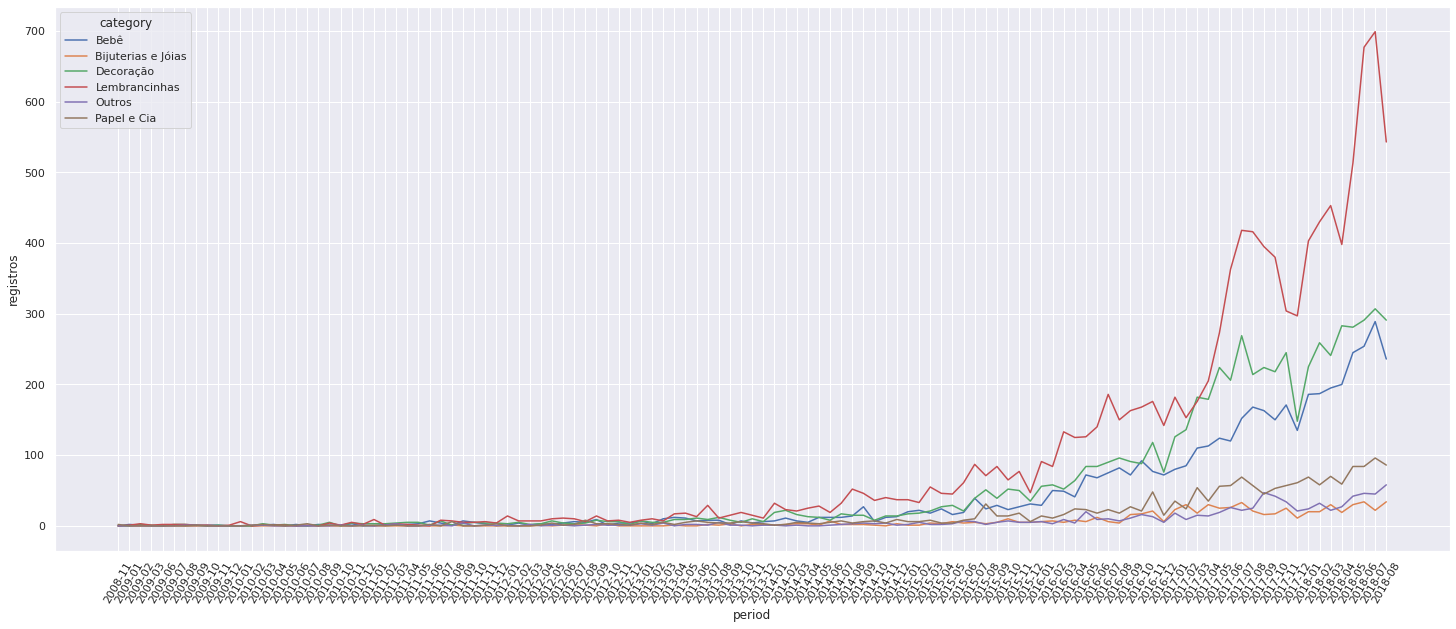

In [18]:
agg_frame = aggregate_by_columns(frame.drop_duplicates('product_id'), 
                                 columns=['category', 'period'], 
                                 group_columns=['category', 'period'], 
                                 records=len(frame))
sns.lineplot(data=agg_frame, x="period", y="registros", hue="category")
plt.xticks(rotation=60)
del agg_frame

O entendimento das questões iniciais relacionadas a categorias foram:
 - Há desbalanceamento entre as classes?
 > Sim. A classe majoritária (Lembrancinhas) é 15 vezes mais numerosa do que a menos frequente (Bijuterias e Jóias).

 - Se houver desbalanceamento, ele muda ao longo do tempo?
 > Para as 4 categorias mais frequentes, a predomância ao longo do tempo raramente muda. As 2 categorias menos frequente têm mudança ocasional de posição entre si.


## Análise Simulada de Mudanças entre Treino e Teste

No primeiro notebook, fez-se uma análise superficial do conteúdo do conjunto de dados e a avaliação de elementos que poderiam inflar as métricas de avaliação com o vazamento de informações dos dados de treino nos dados de teste. Nesta seção espera-se ter uma visão sobre o que esperar de mudança ao utilizar os modelos nos dados não vistos, de teste. 

Para fazer a análise, é possível simular uma nova divisão temporal entre os dados para identificar pontos de atenção que devem ser observados na hora de criar o modelo. Assim, serão criados dois conjuntos: pseudo-treinamento e pseudo-teste.

O ponto de corte pode ser obtido pela análise feita no primeiro notebook. Considerando que há uma diferença de ~15% entre o período de 2018-05 e 2018-08 (este segundo, é o limite atual do dataset), o primeiro período será utilizado como critério de corte. Apesar da proporção semelhante, é importante observar que os ~15% do conjunto de treino estão espalhados em um intervalo mais amplo de meses, o que deve implicar diferenças ainda maiores do que as que serão observadas neste corte simulado de 3 meses.

In [19]:
cut_off_period = '2018-05'
split_frame = set_dataset_split(frame, cut_off_period)

pseudo_training_frame = split_frame.loc[lambda f: f['group'] != 'test'].drop(columns=['group'])
pseudo_test_frame = split_frame.loc[lambda f: f['group'] == 'test'].drop(columns=['group'])

print('Conjuntos de dados:')
print(f' - Treinamento Completo: {len(frame)}')
print(f' - Pseudo-Treino: {len(pseudo_training_frame)} ({100 * len(pseudo_training_frame) / len(frame):.2f}%)')
print(f' - Pseudo-Teste: {len(pseudo_test_frame)} ({100 * len(pseudo_test_frame) / len(frame):.2f}%)')

del split_frame

Conjuntos de dados:
 - Treinamento Completo: 32746
 - Pseudo-Treino: 27144 (82.89%)
 - Pseudo-Teste: 5602 (17.11%)


In [20]:
def extract_tokens(frame: pd.DataFrame, raw_column_name: str, split_pattern: re.Pattern) -> set:
    tags = (frame
            .assign(tag=lambda f: f[raw_column_name].apply(lambda x: split_pattern.split(str(x))))
            .explode('tag')
            .loc[lambda f: f['tag'].apply(lambda x: len(x.strip()) > 0)]
            ['tag']
            .tolist())

    return tags

comparisons = []

for column in frame.columns:

    if column == 'concatenated_tags':
        training_values = set(extract_tokens(pseudo_training_frame, 'concatenated_tags', tag_split_pattern))
        test_values = set(extract_tokens(pseudo_test_frame, 'concatenated_tags', tag_split_pattern))
    else:
        training_values = set(pseudo_training_frame[column].tolist())
        test_values = set(pseudo_test_frame[column].tolist())

    comparisons.append(
        (column,
         len(training_values),
         len(test_values),
         len(training_values & test_values),
         len(training_values | test_values),
         len(training_values - test_values),
         len(test_values - training_values)
        )
    )

comparisons_frame = pd.DataFrame(comparisons, columns=['Column', 'A', 'B', 'A and B', 'A or B','A - B',  'B - A'])

display(HTML('<h3>Comparar valores comuns entre (Pseudo)Treinamento e (Pseudo)Teste</h3>'))
print('Legenda:\n - A = Treinamento\n - B = Teste\n\n')
display(comparisons_frame
        .assign(**{f'A and B %': lambda f: (f['A and B'] / f['A'] * 100).apply(lambda v: f'{v:.2f}%'),
                   f'A or B %': lambda f: (f['A or B'] / f['A'] * 100).apply(lambda v: f'{v:.2f}%'),
                   f'A - B %': lambda f: (f['A - B'] / f['A'] * 100).apply(lambda v: f'{v:.2f}%'),
                   f'B - A %': lambda f: (f['B - A'] / f['A'] * 100).apply(lambda v: f'{v:.2f}%')
                  })
        .style.set_properties(**{'width': '75px'})
       )

del comparisons, comparisons_frame
del pseudo_training_frame, pseudo_test_frame

Legenda:
 - A = Treinamento
 - B = Teste




,Column,A,B,A and B,A or B,A - B,B - A,A and B %,A or B %,A - B %,B - A %
0,product_id,21064,4092,0,25156,21064,4092,0.00%,119.43%,100.00%,19.43%
1,seller_id,6592,1996,1190,7398,5402,806,18.05%,112.23%,81.95%,12.23%
2,query,5623,2496,2170,5949,3453,326,38.59%,105.80%,61.41%,5.80%
3,search_page,5,5,5,5,0,0,100.00%,100.00%,0.00%,0.00%
4,position,39,39,39,39,0,0,100.00%,100.00%,0.00%,0.00%
5,title,18126,3713,330,21509,17796,3383,1.82%,118.66%,98.18%,18.66%
6,concatenated_tags,6727,3132,2577,7282,4150,555,38.31%,108.25%,61.69%,8.25%
7,creation_date,21060,4090,0,25150,21060,4090,0.00%,119.42%,100.00%,19.42%
8,price,12100,3676,2202,13574,9898,1474,18.20%,112.18%,81.80%,12.18%
9,weight,1090,499,426,1163,664,73,39.08%,106.70%,60.92%,6.70%


Como é possível observar, a separação entre os dados de treinamento e de teste expõe preocupações que devem existir caso se construa um modelo e o aplique a dados de produção.

Algumas preocupações que deverão ser consideradas:
 - Todos os **produtos** serão novos, então o modelo deve precisar generalizar o aprendizado para ter uma boa eficácia;
 - Existe repetição de **vendedores** (18%);
 - Existe grande repetição de entre as **buscas** dos dois conjuntos de dados (38%);
 - Seja **página de busca** ou **posição**, ambos os conjuntos possuem o mesmo conjunto de valores -- é interessante saber se foi algo controlado na extração ou se o comportamento dos usuários levou a isso;
 - **Títulos de produtos** são bastante diversos e possuem pouca interseção (~2%);
 - Há bastante **tags**, que foram comparadas individualmente, compartilhadas entre os dois conjuntos (~38%);
 - Como esperado, não há **datas de criação** em comum;
 - A comparação entre os **preços** e **pesos** não é a ideal, mas é possível encontrar valores em comum (18% e 39%). Para preço, deve-se esperar uma mudança do valor ao longo do tempo. Para ambos os atributos, pode-se fazer um estudo no próprio conjunto de treinamento para identificar mudanças de compartamento em geral ou para o mesmo produto do mesmo vendedor;
 - Como é uma coluna binária, **pronta entrega**  possui ambos os valores compartilhados;
 - Há diversidade maior de **quantidade mínimas** nos dados de treinamento e há algumas poucas inéditas nos dados de teste;
 - Há grande quantidade de **contagens** em comum (48%), **para visualizações e pedidos**, entre os conjuntos. Como os dados de teste possuem produtos mais novos e há o janelamento de 30 meses, há uma contribuição para a repetição dos valores.
 - As **categorias**, que são apenas 6, estão presentes em ambos os conjuntos, como verificado anteriormente;
 - São 112 **meses** na base de treino e 3 em teste, totalmente disjuntos. Aqui, é possível notar como o período de 3 meses do teste concentra uma quantidade grande de novos produtos em comparação com outros períodos do conjunto de treinamento. 
  
Dentre os itens observados, os que levantaram um ponto de atenção foram os itens query, título e tags. Como esses elementos, de natureza textual, devem ser importantes para ajudar a determinar a categoria do item ou a inteção do usuário, **a baixa interseção de conteúdo entre os conjuntos de treinamento e de teste deve exigir cuidados adicionais para se lidar com palavras ou tags novas**. Para isso, pode ser interessante trabalhar em um nível de sílabas ou transferir conhecimento de um conjunto de palavras mais amplo, seja de algo como um conjunto de dados externo, uma ontologia/tesauro, ou de um modelo de *embeddings* treinado em um conjunto de dados volumoso.